"In The Name Of ALLAH"
# Computational Intelligence Lab Project - Mr. Amini
## Simple Word Recognition using CNN
Seyed Mohammadsaleh Mirzatabatabaei (smsmt@aut.ac.ir) - 9623105 

---

![main image](https://data-flair.training/blogs/wp-content/uploads/sites/2/2019/07/speech-recognition-using-CNN.png)



## Packages and Dependencies

In order to perform this task, I'm using *Google Colab* environment, I will use *soundfile* and *librosa* libraries for soundfile processing in future and I will create the model using *keras* tensorflow API. 

Following libraries will be used throughout this code, make sure you’ve installed it before trying out the codes.
**librosa, soundfile, keras, tensorflow, scikit-learn, numpy, matplotlib**

So let's import packages and dependencies which we need for our word recognition engine:

In [1]:
from google.colab import files
import sys, os
import glob
from IPython.display import Audio
from zipfile import ZipFile
from tqdm import tqdm
import shutil
import librosa
import soundfile as sf

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Upload Train Dataset

For this project there are basically six classes to recognize from. There is no problem to add as much as you may wish. You should just change in number of model category output and input dataset, labels a bit.
The task in this project will be to classify an audio between six words in farsi language:
*   Garm
*   Sard
*   Roshan
*   Tarik
*   Khodkar
*   Dasti




We will use our own dataset which we have collected for this project.
This database has been collected by **Telegram** messengers (social network), thanks its voice recording.
First we record voice data from about 250 different people varrying the sex, age and save these data, then we categorized each voice data to its specific group (labeling) and did the task of data cleaning and converting its format from **.ogg** to **.wav**. This dataset has been prepared after several days of efforts by a group of 10 people.


Each folder contains approximately 250 audio files for each word. The name of the folder is actually the label of those audio files. You can play some audio files randomly to get an overall idea.

Before start the code you should upload your dataset: (as we use Farsi dataset)



In [3]:
print("Please drag and drop Dataset.zip file in the Colab files folder" +
      "\nor select your Dataset (Dataset.zip):\n")
# files_model = files.upload()

labels = ['Dasti', 'Garm', 'Khodkar', 'Roshan', 'Sard', 'Tarik']
path = '/content/'

for label in labels:
  dirpath = os.path.join(path, label)
  if os.path.exists(dirpath) and os.path.isdir(dirpath):
    shutil.rmtree(dirpath)
dataset = ZipFile("/content/drive/MyDrive/Farsi_Dataset.zip", 'r')
dataset.extractall('')
dataset.close()
print("dataset files unzipped...")

Please drag and drop Dataset.zip file in the Colab files folder
or select your Dataset (Dataset.zip):

dataset files unzipped...


## Data preparation

Due to the lack of data in the collected database, we will add some *noise* to each data and use it as new data for network training. The extra noise power is calculated according to the power of each signal so that the audio signal is not completely damaged.

In this way, we will have about **500** data for each word to train our word recognition network.
We will use one 1 audio channel (mono) to read each voice. Thus, for each sound, we will have a signal with a specific sampling frequency, The sampling frequency of the input dataset signals is **54,000 Hz,** which we did not change.

To clear the data, we read the zero values ​​after reading the audio signals from both sides. (trimming)

Finally, we sorted data by numbers and the original audio file and the noise file are stored in a folder with the word name as the label.

In [12]:
for label in labels:
  folderpath = os.path.join(path, label)
  i = 1
  for file in os.listdir(folderpath):
    filename = file.split('.')[0]
    signal, Fs = librosa.load(os.path.join(folderpath, file), mono=True, sr=None)
    new_signal = np.trim_zeros(signal)

    target_snr_db = 20
    sigp_avg = np.mean(new_signal ** 2)
    sigp_avg_db = 10 * np.log10(sigp_avg)
    noise_avg_db = sigp_avg_db - target_snr_db
    noise_avg = 10 ** (noise_avg_db / 10)
    mean_noise = 0
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg), len(new_signal ** 2))
    noised_signal = new_signal + noise
    
    os.remove(os.path.join(folderpath, file))
    sf.write(os.path.join(folderpath, f'{i}.wav'), new_signal, Fs)
    sf.write(os.path.join(folderpath, f'{i}_noised.wav'), noised_signal, Fs)
    i = i + 1
  print(f'{label} files added...')

Dasti files added...
Garm files added...
Khodkar files added...
Roshan files added...
Sard files added...
Tarik files added...


## Pre-processing Functions

> We have two key problem for preparing data to feed into the neural network.

1.   We can’t just feed an audio file to a CNN, that’s outrageous!
2.   We need to prepare a fixed size vector for each audio file for classification.

> What's the solution?

1.   We could use an embedding to overcome this problem, An embedding is a mapping from discrete objects, such as words vectors of real numbers.
There are a lot of techniques and python packages for audio feature extraction. We use the most obvious and simple one which is called **MFCC encoding**, which is super effective for working with speech signals.

2.   To overcome this problem all we need to do is to pad the output vectors with constant value 0.
MFCC vectors might vary in size for different audio input, CNN can’t handle sequence data so we need to prepare a fixed size vector for all of the audio files.


*MFCC (Mel Frequency Cepstral Coefficients): In short,In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.*


> **Functions**

*   **wav2mfcc:**  In this function we will process the signal and get its **MFCC** so finally we are pooling signal with 0 to the size of pre defined *max_width*

![mfcc](https://image.slidesharecdn.com/speakerrecognitionusingmffc-131219065136-phpapp01/95/speaker-recognition-using-mfcc-8-638.jpg?cb=1403413530)

*   **save_mfcc_model:**  Reads all sound files from each labeled directory and do the mfcc transform then save the mfcc created matrices in a .npy file which is named after the name of the label to use for training network.

In [14]:
def wav2mfcc(signal, Fs=54000, max_width):
  mfcc = librosa.feature.mfcc(signal, sr=Fs)
  mfcc = np.pad(mfcc, pad_width=((0, 0), (0, max_width - mfcc.shape[1])), mode='constant')
  return mfcc


def save_mfcc_model(data_path, model_path, max_width):
  for label in labels:
      mfcc_vectors = []
      folderpath = os.path.join(data_path, label)
      for file in tqdm(glob.glob(f"{data_path}/{label}/*.wav"), f"Saving mfcc numpy model of word '{label}'"):
          signal, Fs = librosa.load(file, mono=True, sr=None)
          mfcc = wav2mfcc(signal, Fs, max_width)
          mfcc_vectors.append(mfcc)
      np.save(os.path.join(model_path, f'{label}.npy'), mfcc_vectors)


max_width = 0
for label in labels:
  for file in glob.glob(f"{path}/{label}/*.wav"):
    signal, Fs = librosa.load(file, mono=True, sr=None)
    mfcc = librosa.feature.mfcc(signal, sr=Fs)
    max_width = max(max_width, mfcc.shape[1])
save_mfcc_model(path, path, max_width)

Saving mfcc numpy model of word 'Tarik': 100%|██████████| 908/908 [00:13<00:00, 67.70it/s]


## Model class

In [15]:
class Model:
  def __init__(self, labels, mfcc_shape, model_path):
    self.mfcc_shape = mfcc_shape
    self.labels = labels
    self.num_labels = len(labels)
    self.model_path = model_path
    self.model = self.get_model()


  def get_model(self):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', input_shape=(self.mfcc_shape[0], self.mfcc_shape[1], 1)))
    model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(self.num_labels, activation='softmax'))
    model.compile(loss = keras.losses.categorical_crossentropy,
                  optimizer = keras.optimizers.Adam(),
                  metrics=['accuracy'])
    model.summary()
    return model


  def get_data(self, model_path, test_size):
    X = np.empty([1, self.mfcc_shape[0], self.mfcc_shape[1]])
    y = np.array([])
    for i, label in enumerate(self.labels):
      label_x = np.load(f'{model_path}/{label}.npy')
      X = np.vstack((X, label_x))
      y = np.append(y, np.full(label_x.shape[0], fill_value=i))
    X = np.delete(X, 0, axis=0)

    return train_test_split(X, y, test_size= test_size, random_state=42, shuffle=True)


  def train(self, epochs=50, batch_size=50, verbose=1, test_size=0.2):
    X_train, X_test, y_train, y_test = self.get_data(self.model_path, test_size)

    X_train = X_train.reshape(X_train.shape[0], self.mfcc_shape[0], self.mfcc_shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], self.mfcc_shape[0], self.mfcc_shape[1], 1)
    y_train_hot = to_categorical(y_train)
    y_test_hot = to_categorical(y_test)
    
    self.hist = self.model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))


  def save(self):
    if not os.path.exists('Model/'):
      os.makedirs('Model/')
    self.model.save('Model/model.h5')
    print("The trained CNN model have been saved in the Model folder.")
    

  def plot_loss(self):
    plt.plot(self.hist.history['loss'])
    plt.plot(self.hist.history['val_loss'])
    plt.title("Model Loss per Epoch")
    plt.legend(['train', 'test'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    plt.savefig('Loss_per_Epoch_final.png', transparent=True)
    plt.close()


  def predict(self, filepath):
    signal, Fs = librosa.load(filepath, mono=True, sr=None)
    new_signal = np.trim_zeros(signal)
    sample = wav2mfcc(new_signal, self.mfcc_shape[1])
    sample_reshaped = sample.reshape(1, self.mfcc_shape[0], self.mfcc_shape[1], 1)
    return self.labels[np.argmax(self.model.predict(sample_reshaped))]

## Create and Train Model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 19, 371, 64)       320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 370, 128)      32896     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 17, 369, 256)      131328    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 184, 256)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 184, 256)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 376832)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

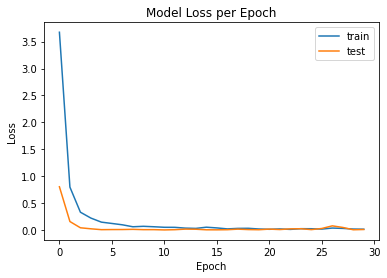

In [22]:
model = Model(labels, (20, max_width), path)

model.train(epochs=30, batch_size=100, verbose=1, test_size=0.2)
model.plot_loss()

**Final epoch:**

loss: 0.0192 - accuracy: 0.9952 - val_loss: 0.0136 - val_accuracy: 0.9973



## Test Result

In [28]:
print("Test data:\n")
files_model = files.upload()
file = [file for file in files_model.keys()]
file_path = os.path.join(path, file[0])

# file_path = '/content/Garm.wav'
result = model.predict(file_path)
print(f'\n\nResult: {result}')

Test data:



Saving Sard.wav to Sard.wav


Result: Sard


## Save Model


In [29]:
model.save()

The trained CNN model have been saved in the Model folder.


## Raspberry Code

Raspberry GPIO pins:

![mfcc](https://projects-static.raspberrypi.org/projects/physical-computing/ddf11cf76ef996ec5fe618e1aec76008bb4b2a96/en/images/pinout.png)


In [ ]:
from gpiozero import LED
from pyaudio import PyAudio as audio

# load model
model = load_model("Model/model.h5")

# audio recording setting
form = pyaudio.paInt16
chans = 1
samp_rate = 54000
chunk = 4096
record_secs = 4     #record time
dev_index = 2
wav_output_filename = 'test.wav'

#setup audio input stream
stream = audio.open(format=form, rate=samp_rate, channels=chans, input_device_index=dev_index, input=True, frames_per_buffer=chunk)
print("recording")
frames=[]
for ii in range(0,int((samp_rate/chunk)*record_secs)):
    data=stream.read(chunk,exception_on_overflow = False)
    frames.append(data)
print("finished recording")
stream.stop_stream()
stream.close()
audio.terminate()

# creates wave file with audio read in
wavefile = wave.open(wav_output_filename, 'wb')
wavefile.setnchannels(chans)
wavefile.setsampwidth(audio.get_sample_size(form))
wavefile.setframerate(samp_rate)
wavefile.writeframes(b''.join(frames))
wavefile.close()

# Raspberry led labels
auto_led = LED(2)
Garm = LED(3)
Sard = LED(4)
Roshan = LED(17)
Tarik = LED(27)

result = model.predict(wav_output_filename)

# automatic setting
if result = 'Khodkar':
  auto = True
  auto_led.on()
else if result = 'Dasti':
  auto = False
  auto_led.off()

# actions
if auto:
  if result = 'Garm':
    Sard.off()
    Garm.on()
  else if result = 'Sard':
    Garm.off()
    Sard.on()
  else if result = 'Roshan':
    Tarik.off()
    Roshan.on()
  else if result = 'Tarik':
    Roshan.off()
    Tarik.on()